## 08-随机森林在乳腺癌数据集上的调参

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
cancer = load_breast_cancer()
cancer.data.shape

(569, 30)

**建模**

In [3]:
rfc = RandomForestClassifier(n_estimators=100, random_state=0)
score_pre = cross_val_score(rfc, cancer.data, cancer.target).mean()
score_pre

0.9631113181183046

### **随机森林调参第一步：n_setimators**

41 0.9648812296227293


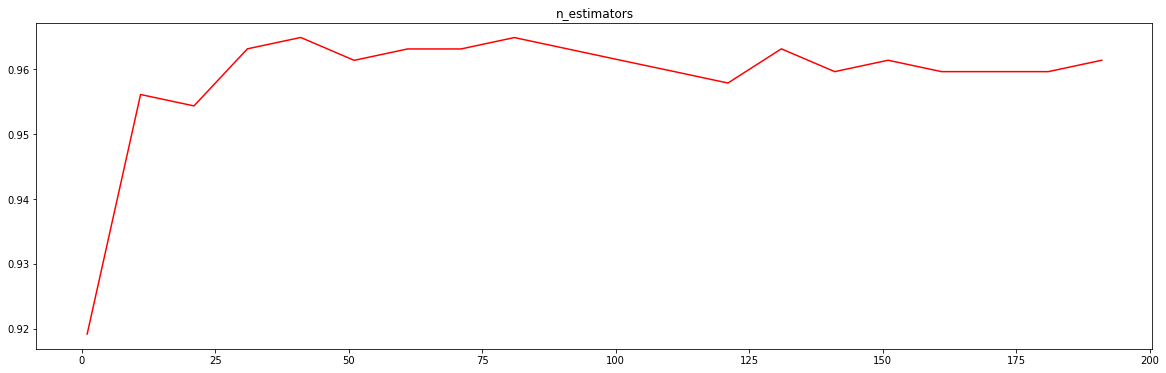

In [4]:
scores_l = []
for i in range(0, 200, 10):
    rfc = RandomForestClassifier(n_estimators=i+1
                                 ,n_jobs=-1
                                 ,random_state=3)
    score = cross_val_score(rfc, cancer.data, cancer.target).mean()
    scores_l.append(score)

# 学习曲线
plt.figure(figsize=(20,6))
plt.plot(range(1, 201, 10), scores_l, color='red')
print([*range(1,201,10)][scores_l.index(max(scores_l))], max(scores_l))
plt.title('n_estimators')
plt.show()

**确定好范围后，细化学习曲线**

37 0.9666356155876417


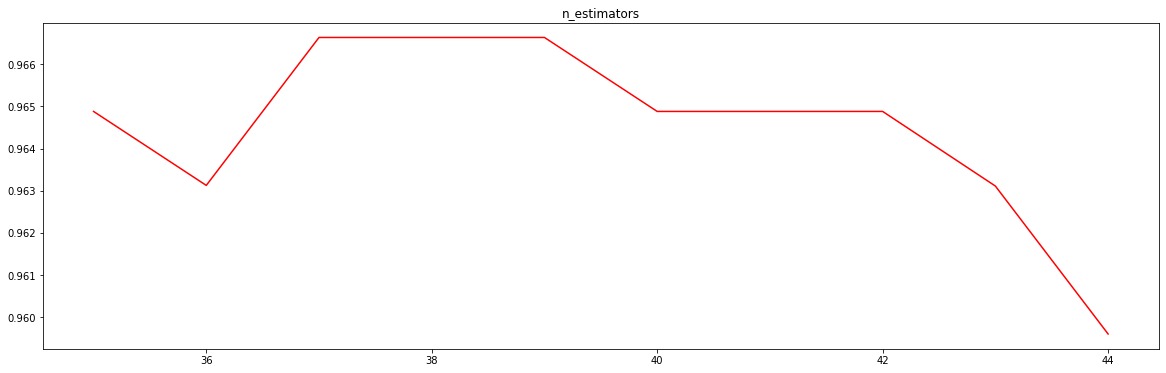

In [22]:
scores_l = []
for i in range(35, 45, 1):
    rfc = RandomForestClassifier(n_estimators=i
                                 ,n_jobs=-1
                                 ,random_state=3)  # random_state保持一致
    score = cross_val_score(rfc, cancer.data, cancer.target).mean()
    scores_l.append(score)

# 学习曲线
plt.figure(figsize=(20,6))
plt.plot(range(35, 45, 1), scores_l, color='red')
print([*range(35,45)][scores_l.index(max(scores_l))], max(scores_l))
plt.title('n_estimators')
plt.show()

调参后，模型表现提升了0.0017，还是有效果的，接下来进入网格搜索。我们将用网格搜索对参数逐个进行调整，为什么不同时调整多个呢？原因有两个：一是因为同时运行多个参数会非常缓慢；二是因为同时调整多个参数，**会让我们无法理解参数的组合是怎么来的**，所以即使调参出来的效果不好，也不知道如何去改。在这里，为了使用复杂度-泛化误差方法，将对参数一个一个进行调整。

### **第二步：为网格搜索做准备**

有一些函数没有参考范围，这种情况我们使用学习曲线，看趋势；确定大致范围后，再跑曲线

"""
param_grid = {'n_estimators': np.arange(0, 200, 10)},

param_grid = {'max_depth': np.arange(1, 20, 1)},

param_grid = {'max_leaf_nodes': np.arange(25, 50, 1)}  # 限制叶子结点数量
    对于大型数据集，可以从1000来构建，每100个叶子一个区间，再缩小范围

"""

有一些参数是有大致的取值范围，或者我们知道随着它的取值范围的变化，模型整体的准确率如何变化，这样的参数就可以直接跑网格搜索

In [ ]:
"""
param_grid = {'criterion': ['gini', 'entropy']},

param_grid = {'min_samples_split': np.arange(2, 2+20, 1)},
    一般先从20开始调整，效果不理想，再往大调整

param_grid = {'min_samples_leaf': np.arange(1, 1+20, 1)},
    一般先从10开始调整，效果不理想，再往大调整

param_grid = {'max_features': np.arange(5, 30, 1)}  # 每次划分特征时，考虑的特征数量；特征小于50的时候一般使用所有的
    一般会以特征数量为基础，要么取（1，sqrt(n)）,要么取（sqrt(n), n），先根据结果确定在泛化误差的左侧还是右侧，再次基础上进行网格搜索

"""

**按照参数对模型的影响大小进行调参，先调整max_depth**

In [7]:
param_grid = {'max_depth': np.arange(1, 20, 1)}

# 一般会根据数据大小来进行一个试探，乳腺癌数据集很小，可以用1-10，或者1~20这样的试探
# 但对于向digit recognition这样的大型数据来说，应该先尝试30~50层深度（或许还不够）
# 更应该画出学习曲线，，来观察深度对模型的影响

rfc = RandomForestClassifier(n_estimators=37
                             ,random_state=3   # random_state要保持一致
                            )
GS = GridSearchCV(rfc, param_grid, cv=10)
GS.fit(cancer.data, cancer.target)

GS.best_params_
GS.best_score_

0.9631578947368421

In [8]:
GS.best_params_

{'max_depth': 5}

In [9]:
GS.best_score_

0.9631578947368421

调整参数为1~20后，准确率下降了。限制max_depth，是把模型复杂度降低，在泛化误差曲线上往左推，而模型整体的准确率下降了，即泛化误差上升，说明模型此时位于泛化误差曲线最低点左侧。**通常来说**，随机森林一般位于泛化误差曲线最低点右侧，模型应该倾向于过拟合，而不是欠拟合。这和数据集本身有关，也有可能是我们调整的n_estimators太大，因此将模型拉到泛化误差最低点去了（此时再调整max_depth就更往左推了）。**然而既然我们追求的是泛化误差最小，那么需要保留这个n_estimators,除非有其他因素可以帮我们得到更好的准确率。**

当模型位于泛化误差最低点左侧时，我们需要做的是增加模型复杂度（增加方差，减小偏差），因此max_depth应该尽量大，min_samples_leaf和min_samples_split都应该尽量小（模型中这两个参数默认的已经是最小了）。（而我们的调参是把max-depth往小，其他两个往大调的）。这几乎是在说明除了max_features之外，我们没有其他参数可以调整（因为max_features默认是处于中间的，不是最大，也不是最小）。因为max_depth，min_samples_leaf，min_samples_split都是剪枝参数，是减小复杂度的参数。在这里我们可以预言，我们已经非常接近模型的上限，模型没有什么进步的空间了。

**调整max_features**

In [21]:
param_grid = {'max_features': np.arange(5, 30, 1)}

# max_features是唯一一个既能把模型往左推，也能把模型往右推的参数。
# 我们需要根据调参前，模型所在的位置来决定把max_features往哪边调整
# 现在模型位于泛化误差最低点左侧（根据max_depth等的调参确定），我们需要更高的复杂度，应该把max_features往更大的方向调整，可用的特征越多，模型才会越复杂。
# max_features默认值为sqrt(n)，我们用它作为最小值

rfc = RandomForestClassifier(n_estimators=37
                             ,random_state=3   # random_state要保持一致
                            )
GS = GridSearchCV(rfc, param_grid, cv=10)
GS.fit(cancer.data, cancer.target)

# GS.best_params_
# GS.best_score_

# 这里我的思考有误，认为要提高复杂度需要把max_features往更小的方向调整，因为max_features越小，模型划分越，需要的树越多，复杂度越高。
# 这个看法错误在于，其他的参数都已经确定了，不会再收到影响了。应该只考虑特征与模型复杂度之间的直接关系

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_estimators=37, random_state=3),
             param_grid={'max_features': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29])})

In [22]:
GS.best_params_

{'max_features': 8}

In [23]:
GS.best_score_

0.968421052631579

观察到修改max_features之后，模型准确率上升。说明我们把模型往右推，泛化误差减少了。说明已经达到泛化误差最低点，没有参数可以左右的不分了。剩下的误差是由噪声决定的，已经没有偏差和方差可以发挥作用的地方了。

**如果是现实案例，我们到这一步就可以停下了。因为复杂度和泛化误差的关系告诉我们，模型不能再进步了。调参和训练模型都需要很长时间，明知道模型不能进步了还继续调参，不是一个有效率的做法。如果我们希望模型更进一步，应该更换算法，或者更换数据预处理的方式。**

出于实验的目的，我们接下来继续对叶子节点调参

**调整min_samples_leaf**

In [14]:
param_grid = {'min_samples_leaf': np.arange(1, 1+10, 1)}

# 对于min_samples_leaf和min_samples_split，一般是从最小是开始往上加 10或者20
# 对于高维度高样本量的数据，也可以直接 +50，对于大型数据可能需要200~300的范围
# 如果调整时发现准确率无论如何都上不来，可以调一个很大的数据，大力限制模型的复杂度
rfc = RandomForestClassifier(n_estimators=37
                             ,random_state=3   # random_state要保持一致
                            )
GS = GridSearchCV(rfc, param_grid, cv=10)
GS.fit(cancer.data, cancer.target)

# GS.best_params_
# GS.best_score_

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_estimators=37, random_state=3),
             param_grid={'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])})

In [15]:
GS.best_params_

{'min_samples_leaf': 3}

In [16]:
GS.best_score_

0.9666666666666666

这和我们预料的不一样，这和max_depth的情况不一致，模型往左推了，泛化误差下降了。与前面的参数得到的结论相反，可能是因为数据集本身的问题造成。我们需要接着调别的参数，来验证这个结论。

在最终得到的模型中，我们可以尝试加入和不加入这个参数，观察准确率的变化，来进一步验证。事实证明，加入该参数后，准确率下降，缺失是数据集本身的问题。

**调整min_samples_split**

In [24]:
param_grid = {'min_samples_split': np.arange(2,2+20, 1)}

# 对于min_samples_leaf和min_samples_split，一般是从最小是开始往上加 10或者20
# 对于高维度高样本量的数据，也可以直接 +50，对于大型数据可能需要200~300的范围
# 如果调整时发现准确率无论如何都上不来，可以调一个很大的数据，大力限制模型的复杂度
rfc = RandomForestClassifier(n_estimators=37
                             ,random_state=3   # random_state要保持一致
                            )
GS = GridSearchCV(rfc, param_grid, cv=10)
GS.fit(cancer.data, cancer.target)

# GS.best_params_
# GS.best_score_

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_estimators=37, random_state=3),
             param_grid={'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21])})

In [25]:
GS.best_params_

{'min_samples_split': 3}

In [26]:
GS.best_score_

0.9648809523809524

模型往左推，泛化误差上升了。...................

**最后尝试调整criterion**

In [27]:
param_grid = {'criterion': ['gini', 'entropy']}

# creiterion对于模型的影响是未知的
rfc = RandomForestClassifier(n_estimators=37
                             ,random_state=3   # random_state要保持一致
                            )
GS = GridSearchCV(rfc, param_grid, cv=10)
GS.fit(cancer.data, cancer.target)


# GS.best_params_
# GS.best_score_

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_estimators=37, random_state=3),
             param_grid={'criterion': ['gini', 'entropy']})

In [28]:
GS.best_params_

{'criterion': 'entropy'}

In [29]:
GS.best_score_

0.9649122807017545

调整后，准确率反而降低了。

**调参完毕，总结出最佳参数**

In [32]:
rfc = RandomForestClassifier(n_estimators=37
                             ,random_state=3
                             ,max_features=8
                             # ,min_samples_leaf=3
                            )
score = cross_val_score(rfc, cancer.data, cancer.target, cv=10).mean()
score

0.968421052631579

网格所有也可以同时调整多个参数，但是只要输入的参数就必须采用，因此有时不如我们手动调整的效果好。

对于泰坦尼克号数据集进行调参，得到结果后，随机森林效果提升大概2%左右，这对于调参来说已经是一个非常大的进步。不过，泰坦尼克号的调参过程非常缓慢。